# 10. Deep Tree Search with Naive Pruning

MTCS의 아이디어를 접목한 방식으로 오목을 학습하여서
유의미한 수를 일부 둘 수 있을 정도로 학습하는 것이
가능하다는 것을 볼 수 있었습니다.
하지만 이를 이용해서 analysis-based를 이기는 것은
무리가 있었습니다.

여기서는 쉬어가는 파트로,
기존의 analysis-based algorithm을 이용하여
몇 수 앞을 보고 판단하는 간단한 agent를 구현합니다.

## 환경설정

Mock5를 불러옵니다.

In [1]:
!rm -rf *
!git clone https://github.com/lumiknit/mock5.py
!mv mock5.py/mock5 .

Cloning into 'mock5.py'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 129 (delta 58), reused 115 (delta 44), pack-reused 0
Receiving objects: 100% (129/129), 36.27 KiB | 9.07 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [125]:
from mock5 import Mock5
from mock5.analysis import Analysis
import mock5.analysis
from mock5.agent_random import agent as agent_random
from mock5.agent_analysis_based import agent as agent_analysis_based

import matplotlib.pyplot as plt

## Minimax Algorithm

Minimax 알고리즘은 의사결정을 하는 일종의 전략으로,
간단히 말하자면 두 사람끼리 진행하는 게임과
각 상황에 대해 '나'에게 유리한 정도를 나타낸 점수가 있을 때
자신은 그 점수가 최대가 되도록 행동하며,
상대는 그 점수가 최소가 되도록 행동한다는 것입니다.

이 떄문에 만약 깊이 $n$의 결정트리를 가지고 있고
그 결정트리의 leaf node에 대한 점수를 모두
알 수 있다면, 이 점수들에 대해 max-min을 번갈아 구해서
최선의 결과를 구하는 것이 가능합니다.

## Alpha-beta Pruning

Alpha-beta pruning은 minimax algorithm을
적용하는 결정트리에 대해 최적값을 탐색하는 전략입니다.
이 알고리즘의 요점은 DFS로 순회하면서 현재까지 찾아낸
최적값들을 이용해 불필요한 정점은 무시한다 (= 가지치기)는
것입니다.

예를 들어서 beta value (min)을 갖는 자식 노드를
찾고 싶을 때 특정 노드를 탐색할지 여부를 알고싶다면,
일단 그 노드에 대한 점수를 구한 뒤,

- 그 노드의 탐색된 형제 노드 중 그보다 점수가 낮은 것이
있으면 자신은 탐색하지 않아도 됨.
- 자신이 지금까지 탐색한 노드보다 점수가 제일 낮으면서
자신의 탐색된 삼촌 노드 중 자신보다 큰 것이 있으면,
현재 값이 부모로 올라가도 그 형제들 중 max를 선택하게
되므로 선택될 수 없음. 따라서 탐색하지 않아도 됨.

이 두 조건을 만족하는 노드를 탐색하지 않도록 합니다.

이 알고리즘을 적용하려면 트리의 임의의 노드에 대한
점수를 어느 정도 알 필요가 있는데, 이는 MCTS 등으로
수렴시켜서 사용해도 됩니다.

## Our Pruning

저희는 위 alpha-beta pruning과 다르게, 비교적
단순무식한 방식으로 가지치기를 해보고자 합니다.

`mock5.Analysis`는 분석이 완료되면 현재 오목판
(state)에 대해 각 칸에 돌을 두었을 때 (action)
그것이 돌을 각 방향으로 얼마나
 연결시키는가를 정수로 (score) 저장해둡니다.
분류는 돌이 이어진 갯수인데, 2목, 3목, 4목, 5목, 장목
순으로 올라갑니다.
다만, 열린 3목과 열린 4목은 그대로 있으면 몇 수 뒤
게임을 확실하게 끝낼 수 있기 때문에 일반 3목이나 4목에
비해 더 높은 점수를 부여해둡니다.
그래서 agent는 이 점수를 합해서
해당 칸에 돌을 두는 것의 가치를 계산하게 됩니다.

한가지 특이할 수도 있는 것은, 자신의 돌이든 상대의 돌이든
같은 방식으로, 별도로 계산을 한다는 것입니다.
이후 최종적으로 판단할 때에는 자신이든 상대든 가치가 가장
높은 칸을 먼저 선택하며, 만약 자신과 상대의 가장 가치가
높은 칸이 같은 가치를 가진다면 자신에게 가치가 높은 칸을
선택합니다.
이유라면 점수가 같다는 것은 나든 자신이든 *현재 수만
봤을 때* 게임을 끝내기까지 걸리는 시간이 같다는 것이기
때문입니다.

이를 이용해서 저희는 다음과 같이 단순히 트리 탐색을
해볼 것입니다:

- 우선 현재 보드판에 대해 분석을 실시하여
각 칸의 가치를 모두 가져옵니다.
- 이 중 가치가 가장 높은 칸 중 $n$개를 선택합니다.
- 이 $n$개의 칸에 돌을 둔 뒤 상황에서 다시 한번
분석을 진행합니다.
- 이 때 분석된 값 중 최댓값이 상대가 선택할 가능성이
높은 값입니다.
- $n$개의 칸 중 이런 최댓값이 가장 작은 위치를 선택합니다.

위의 minimax algorithm을 보면 알겠지만,
이 방식을 단순히 깊이 1이 아니라 더 깊은 곳까지 확장이
가능합니다.
예를 들어서 중간에 상대가 선택할 가능성이 가장
높은 칸을 고르는 부분이 있는데,
상대도 똑같은 방식으로 생각할 것이기 때문에
분석을 한 뒤, 가장 가치가 높은 칸 $m$개를 고르고,
그 중 분석값의 최댓값이 최소인 칸을 고르게 될 것입니다.

이 방식으로 새로운 agent를 만들어보겠습니다.

## Helpers

우선 분석이 완료되었을 때,
특정 플레이어 기준으로
특정 칸의 가치를
계산하는 함수를 만듭니다.

In [96]:
def value_of_color_at(analysis, color, idx):
  acc = 0
  for dir in range(4):
    acc += analysis.result[color][dir][idx]
  return acc

이를 바탕으로 특정 플레이어 기준으로 해당 칸에 돌을 둘 가능성을
계산해볼 수 있습니다.

In [87]:
def value_at(analysis, color, idx):
  my = value_of_color_at(analysis, color, idx)
  op = value_of_color_at(analysis, 3 - color, idx)
  return max(my, op)

In [205]:
def max_value(analysis, color, n):
  result = [(-1, None)] * n
  for i in range(analysis.game.width * analysis.game.height):
    v = value_at(analysis, color, i)
    if analysis.game.board[i] == 0 and v > result[0][0]:
      result[0] = (v, i)
      result.sort()
  return result

아래 함수는 탐색할 너비의 리스트가 주어졌을 때
해당 너비만큼 샘플링하여 minimax와 비슷하게
진행을 시킵니다.

In [206]:
def find_max(game, color, depth, breadths):
  a = Analysis(game)
  lst = []
  if game.history_depth() >= game.height * game.width:
    return 0, 0
  if depth >= len(breadths):
    mv = max_value(a, color, 1)
    return mv[0]
  else:
    b = breadths[depth]
    mv = max_value(a, color, b)
    minv = float('inf')
    mini = None
    for v, i in mv:
      if i is None: continue
      if v >= mock5.analysis.B_OPEN_3: # Open 3 must be blocked
        if minv > -v: minv, mini = -v, i
      elif game.place_stone_at_index(i):
        cv, ci = find_max(game, 3 - color, depth + 1, breadths)
        if minv > cv: minv, mini = cv, i
        game.undo()
    return -minv, mini

아래는 agent를 생성하는 함수입니다.

분석이 제대로 동작하려면 최소한 돌 하나가 있어야 하는데,
이를 위해 첫 수는 무조건 천원에 둡니다.

In [207]:
def agent_deep(breadths):
  def agent(game):
    if game.history_depth() <= 0:
      return game.height // 2, game.width // 2
    v, i = find_max(game, game.player, 0, breadths)
    if i is None: return None
    return game._expand_index(i)
  return agent

예를 들어서 처음에는 5개의 샘플 중 탐색하는데,
각 샘플에 대해 3개의 샘플을 탐색해서 판단하고 싶다면
아래와 같이 사용할 수 있습니다.

In [225]:
a = agent_deep([5, 3])

 [ Turn  50 ; 1P's turn (tone = O) ]
  | 0 1 2 3 4 5 6 7 8 9 A B C D E F G H I
--+--------------------------------------
0 | . . . . . . . . . . . . . . . . . . .
1 | . . . . . . . . . . . . . . . . . . .
2 | . . . . . . . X . . . . . . . . . . .
3 | . . . . . . . . O . . X . . . . . . .
4 | . . . . . . . . . O X . . . . . . . .
5 | . . . . . . . . . X O X . . . X . . .
6 | . . . . . . . . X X O O X . O . . . .
7 | . . . . . . O X X X X O X O . . . . .
8 | . . . . . . O . O X O O O O X . . . .
9 | . . . . . . . . X O O O X X . . . . .
A | . . . . . . . O X O X X O . . . . . .
B | . . . . . . . . O . . . . O . . . . .
C | . . . . . . . X O X . . . . X . . . .
D | . . . . . . . . O . . . . . . . . . .
E | . . . . . . . . . . . . . . . . . . .
F | . . . . . . . . . . . . . . . . . . .
G | . . . . . . . . . . . . . . . . . . .
H | . . . . . . . . . . . . . . . . . . .
I | . . . . . . . . . . . . . . . . . . .
2p (<function agent_deep.<locals>.agent at 0x7f4d1d4563b0>) win!


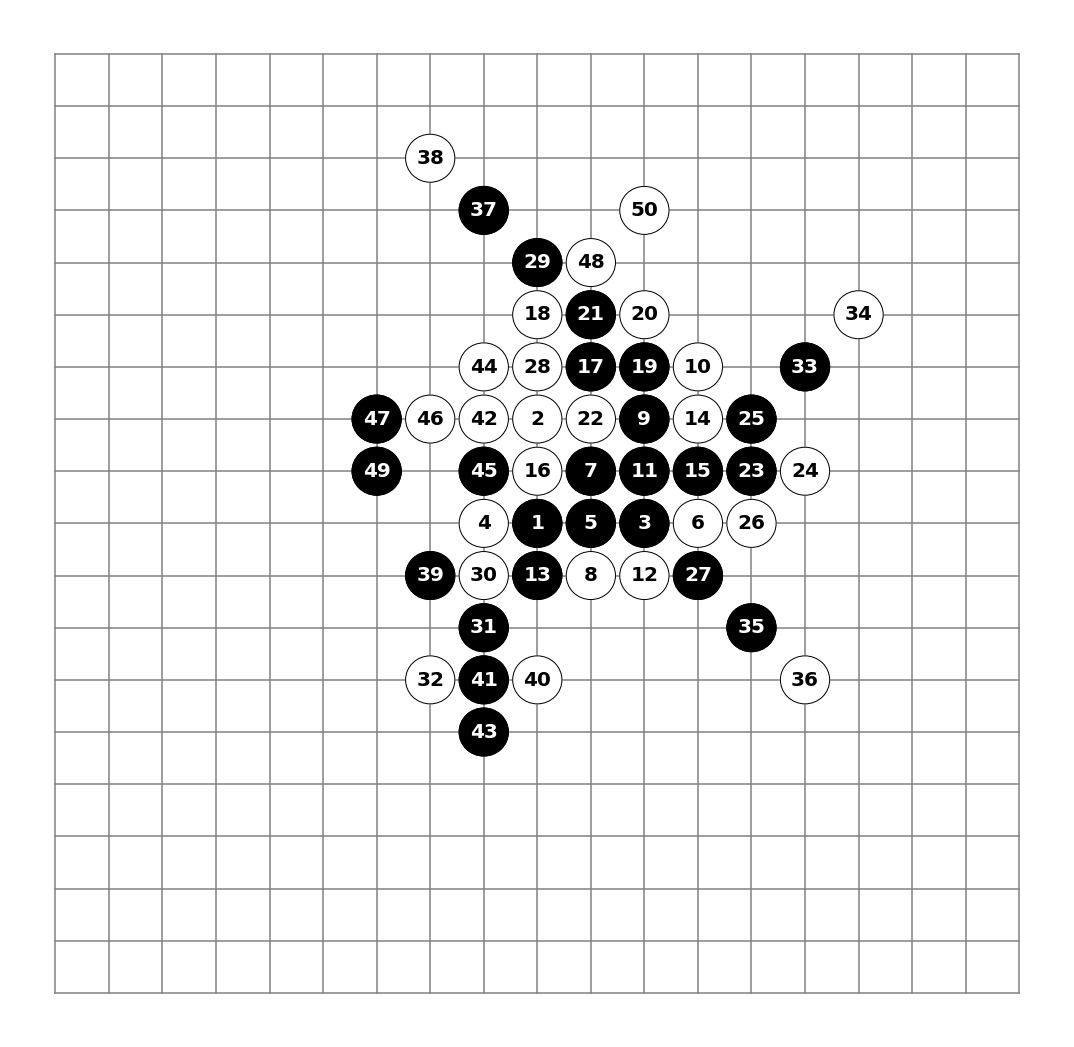

In [226]:
g = Mock5(19, 19)
g.play(agent_analysis_based, a, random_first=False, print_intermediate_state=False)
g.plot()
plt.show()
plt.close()

실행하다보면 중간중간에 deep agent가 지는 경우가
종종 발생합니다.
이는 사실 agent가 모든 경우를 판단하지 않기 때문에
발생하는 문제라고 생각되는데,
궁극적으로는 depth와 breadth를 늘리거나
더 효율적으로 pruning 하는 것 외에는 방법이 없습니다.

## 평가

아래에서는 기존의 Analysis-based와 대결해봅니다.

In [231]:
def vs_ab(h, w, n, agent, name):
  print("-- {} vs analysis-based (h/w={}/{}, n={})".format(name, h, w, n))
  w1, w2, draw = 0, 0, 0
  for i in range(n):
    result = Mock5(h, w).play(agent, agent_analysis_based,
                              print_intermediate_state=False,
                              print_messages=False)
    if result == 1: w1 += 1
    elif result == 2: w2 += 1
    else: draw += 1
  print("{} W/D/L {} / {} / {}".format(name, w1, draw, w2))
  print("WR: {:.3f} / DR: {:.3f}".format(w1 / n, w2 / n))

In [233]:
vs_ab(19, 19, 10, agent_analysis_based, "analysis-based")
vs_ab(19, 19, 10, agent_deep([5]), "deep[5]")
vs_ab(19, 19, 10, agent_deep([3, 3]), "deep[3, 3]")
vs_ab(19, 19, 10, agent_deep([3, 3, 2]), "deep[3, 3, 2]")

-- analysis-based vs analysis-based (h/w=19/19, n=10)
analysis-based W/D/L 4 / 0 / 6
WR: 0.400 / DR: 0.600
-- deep[5] vs analysis-based (h/w=19/19, n=10)
deep[5] W/D/L 10 / 0 / 0
WR: 1.000 / DR: 0.000
-- deep[3, 3] vs analysis-based (h/w=19/19, n=10)
deep[3, 3] W/D/L 6 / 0 / 4
WR: 0.600 / DR: 0.400
-- deep[3, 3, 2] vs analysis-based (h/w=19/19, n=10)
deep[3, 3, 2] W/D/L 7 / 1 / 2
WR: 0.700 / DR: 0.200


실제로는 더욱 많은 횟수를 돌려봐야 정확하지만,
colab에서 위와 같은 횟수를 진행하는 데에 1분 14초가 걸리며,
그 중 대부분은 depth가 최대 3인 마지막 agent가
소모합니다.

Depth가 1인 경우에는 자신의 최댓값 중에서
상대가 공격할 수가 가장 없는 방법만을 찾기 때문에
단순히 analysis-based와 맞붙었을 때 압도하는 모습을
보여줍니다.

더 depth가 깊어지면 현재의 node를 평가하는 함수와
가지치기 전략이 이상적이지 않아서 패배하는 경우를
종종 볼 수 있습니다. 하지만 여전히 유리한 위치에
있음을 알 수 있습니다.

Deep agent들은 모두 결정적으로 동작하다보니
서로 선후공 한번씩만 맞붙어보면 충분합니다.

In [234]:
def vs(h, w, agent1, name1, agent2, name2):
  print("-- Blk {} vs Wht {} (h/w={}/{})".format(name1, name2, h, w))
  result = Mock5(h, w).play(
      agent1, agent2,
      random_first=False,
      print_intermediate_state=False,
      print_messages=False
  )
  print("  {}".format('Black' if result == 1 else 'White' if result == 2 else 'Draw'))
  print("-- Blk {} vs Wht {} (h/w={}/{})".format(name2, name1, h, w))
  result = Mock5(h, w).play(
      agent2, agent1,
      random_first=False,
      print_intermediate_state=False,
      print_messages=False
  )
  print("  {}".format('Black' if result == 1 else 'White' if result == 2 else 'Draw'))

In [239]:
a5 = agent_deep([8])
a43 = agent_deep([4, 3])
a333 = agent_deep([3, 3, 3])
vs(19, 19, a43, 'a43', a5, 'a5')
vs(19, 19, a333, 'a333', a5, 'a5')
vs(19, 19, a333, 'a333', a5, 'a43')

-- Blk a43 vs Wht a5 (h/w=19/19)
  Draw
-- Blk a5 vs Wht a43 (h/w=19/19)
  Draw
-- Blk a333 vs Wht a5 (h/w=19/19)
  Draw
-- Blk a5 vs Wht a333 (h/w=19/19)
  Draw
-- Blk a333 vs Wht a43 (h/w=19/19)
  Draw
-- Blk a43 vs Wht a333 (h/w=19/19)
  Draw


보다시피 승부가 나지 않는 것을 볼 수 있습니다...
어느 정도 차이를 보고싶다면,

 [ Turn 123 ; 2P's turn (tone = X) ]
  | 0 1 2 3 4 5 6 7 8 9 A B C D E F G H I
--+--------------------------------------
0 | . X . O X . . . . . . X O X . . . . .
1 | . O . . X O . . . . . . . X . . . . .
2 | . X . O O X . . O X X O . O X O . . .
3 | . O . X X . O X . . O O X O X X . . .
4 | . . . O . X X O X O X O X . O X O . .
5 | . . . X O O O O X O . X O O O X . . .
6 | . . . O X X X O O X O X O X X O . O .
7 | . . . X . O . X O . O X O . . . X . .
8 | . . . . O . X O X X X O X X X O . . .
9 | . . . O . X X . O O X O O O X O . . .
A | . . . X . . O . . X O X O O O O X . .
B | . X . O . . . . . . X X X O X O . . .
C | . . . . . . . . . . . . X O . O . . .
D | . . . . . . . . . . . . . X . X . . .
E | . . . . . . . . . . . . . . . . . . .
F | . . . . . . . . . . . . . . . . . . .
G | . . . . . . . . . . . . . . . . . . .
H | . . . . . . . . . . . . . . . . . . .
I | . . . . . . . . . . . . . . . . . . .
1p (<function agent_deep.<locals>.agent at 0x7f4d1b290e60>) win!


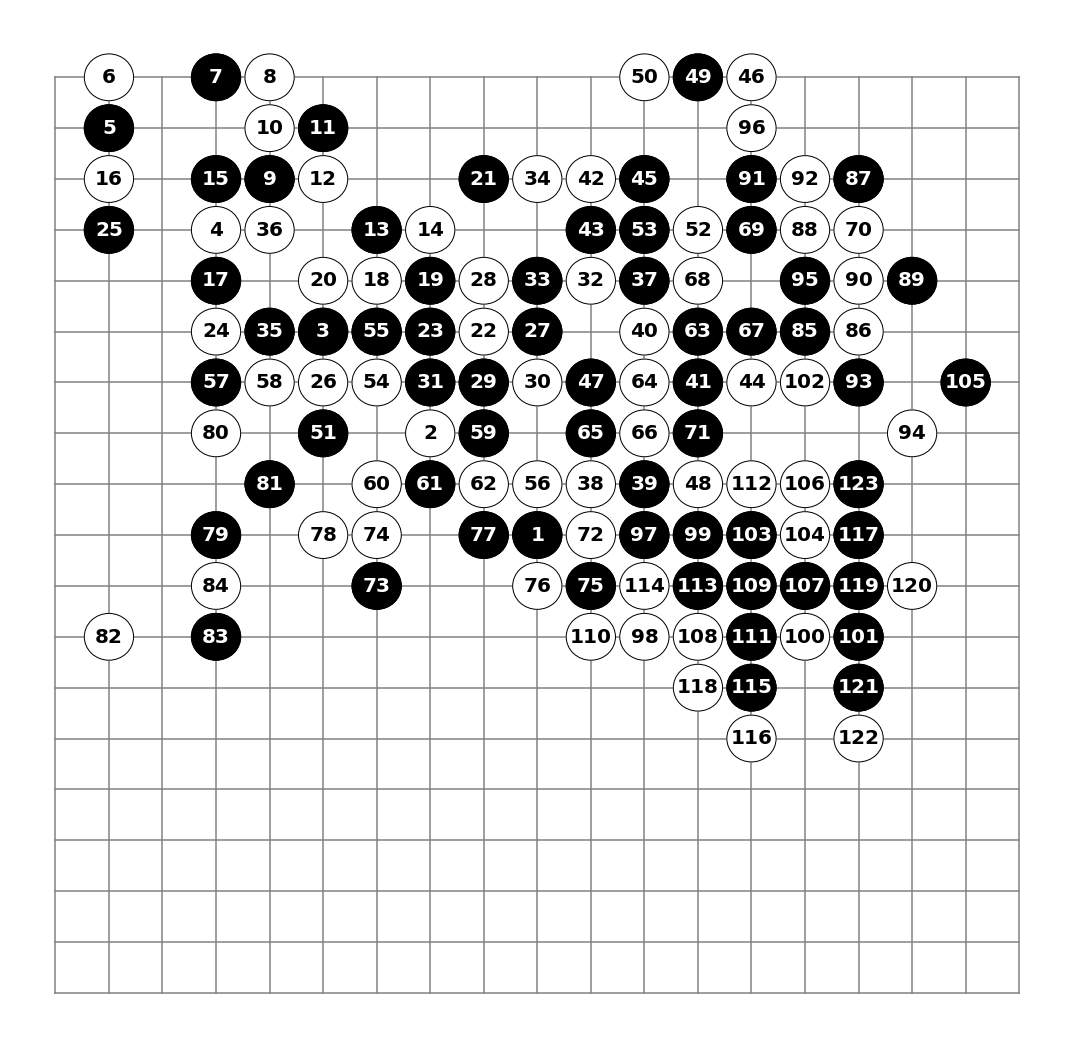

In [242]:
g = Mock5(19, 19)
g.play(agent_deep([4, 4, 4]), agent_deep([3]), random_first=False, print_intermediate_state=False)
g.plot()
plt.show()
plt.close()

위와 같이 애초에 너비 차이로 인해
상대가 못 보는 것을 볼 수 있거나,

 [ Turn 147 ; 2P's turn (tone = X) ]
  | 0 1 2 3 4 5 6 7 8 9 A B C D E F G H I
--+--------------------------------------
0 | . X . . . . X . . . X . . . . . . . .
1 | O O O O X X . O . X O O . . X . . . .
2 | . X X . O X O X O X O X X . O . . . .
3 | X . O X X X O X O X O O O X . . . . .
4 | . . O O X O O . X O O O O X . O . . .
5 | O . X X X O X O X O X X O O O X X . .
6 | . . . . X O . . X . O O X X X . O . .
7 | . O . . O X . X O X O X . O . . . . .
8 | . . . . . . O X . X O X X . O X . . .
9 | . . . . . . X . . O X O O X . O O . .
A | . . . . . . . O X O . X X O X . X . .
B | . . . . . . . X X X O . X O X O . . .
C | . . . . . . . X X O O . X O O . . . .
D | . . . . . . . X O O O X O O . X . . .
E | . . . . . . O X X O X O . X . . . . .
F | . . . . . . O O O O O X . . . . . . .
G | . . . . . . . X . X . . . . . . . . .
H | . . . . . . . . . . . . . . . . . . .
I | . . . . . . . . . . . . . . . . . . .
1p (<function agent_deep.<locals>.agent at 0x7f4d1a9e70e0>) win!


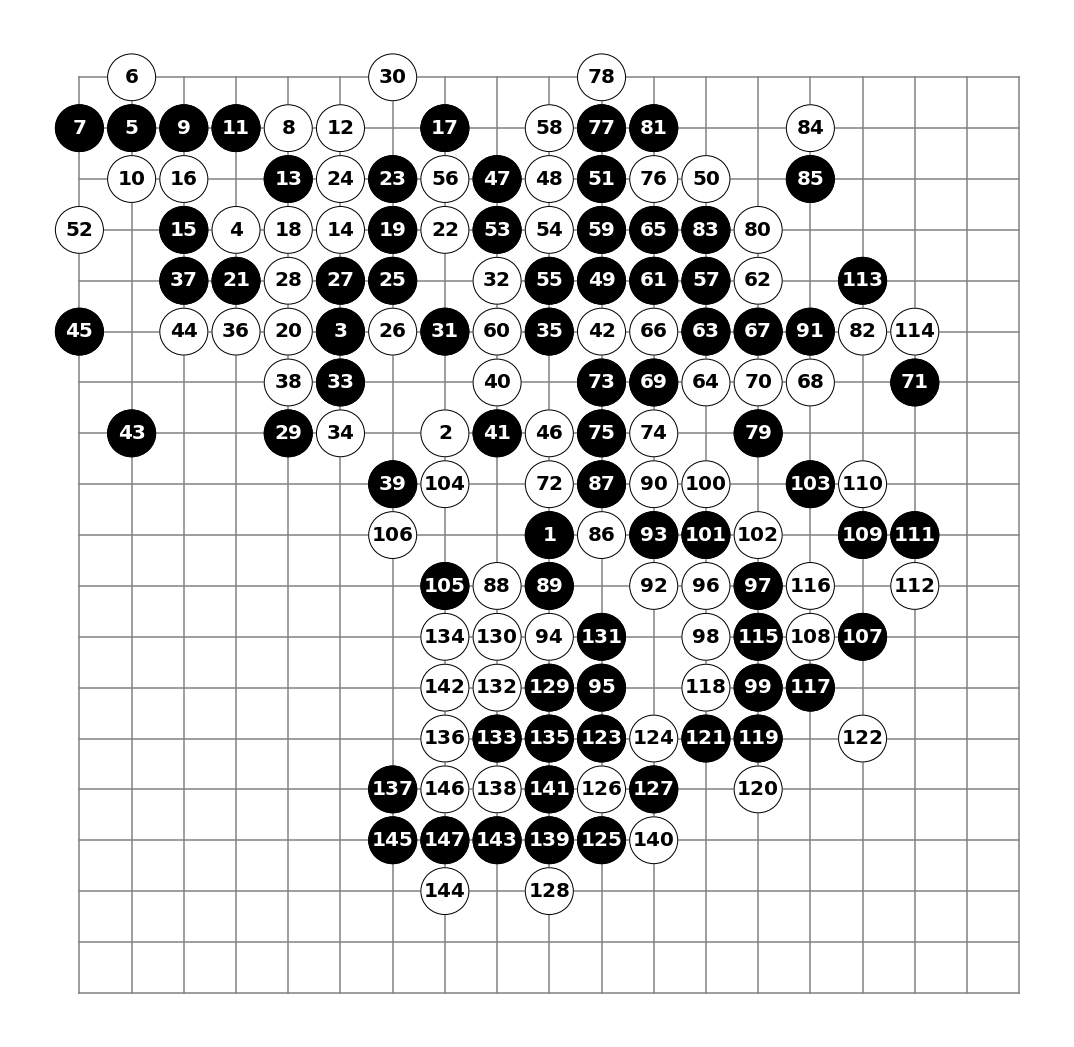

In [247]:
g = Mock5(19, 19)
g.play(agent_deep([4, 3, 2, 2, 2, 2, 2]), agent_deep([4]), random_first=False, print_intermediate_state=False)
g.plot()
plt.show()
plt.close()

상대보다 아득히 먼 수를 볼 수 있어야 합니다.

## 결론

여기서는 점수를 매기는 프로그램과 가지치기 하는 프로그램을
매우 단순하게 작성해서 그렇지만,
실제로 이 둘만 잘 조합하더라도
많은 게임들은 커버할 수 있게 됩니다.
(병렬처리, DB 등을 도입하여 더욱 효율적으로
사용할 수 있습니다.)
또한 깊이 자체는 유동적으로 조절할 수 있고, 깊이에
따라 종료되는 시간이 달라지기 때문에 정확도와 시간 사이에서
조절하는 것이 가능합니다.

다만, 정확도를 위해서는 각 node를 정확히 평가할 필요가
있다는 것이 가장 큰 난점입니다.

이전에 만든 DNN을 이용한 MCTS와 비슷한 모델은
각 정점에 대해 임의로 값을 주는 것이 가능하며,
제대로 수렴했을 경우에는 각 상태에 대한 거의 정확한
평가치를 내놓게 됩니다. 
여기에 위 같이 가지치기를 포함한 트리 탐색을 통해
정확도를 올리는 것이 가능합니다.

일단 본 프로젝트의 목적은 neural network를
바탕으로 오목 인공지능을 만드는 것이며,
analysis-based agent를 넘는 것도 쉽지 않기 때문에
여기서 만든 deep agent는 이후 사용하지는 않습니다.